# importing libraries #

In [1]:
import mne
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mne.decoding import CSP
import matplotlib.pyplot as plt

# Importing File from BCICIV Competition Database

In [2]:
raw = mne.io.read_raw_gdf(r"C:\Users\varun\OneDrive\Documents\Research\BCICIV_2a_gdf\A07T.gdf")
events, _ = mne.events_from_annotations(raw)
raw.load_data()
raw.filter(7., 35., fir_design='firwin')
raw.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude='bads')
tmin, tmax = 1., 4.
# left_hand = 769, right_hand = 770
event_id = dict({'769': 7, '770': 8})
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
labels_all = epochs.events[:, -1]
y=labels_all
data = epochs.get_data()

Extracting EDF parameters from C:\Users\varun\OneDrive\Documents\Research\BCICIV_2a_gdf\A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


C:\Users\varun\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 751 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished
C:\Users\varun\AppData\Local\Temp\ipykernel_35864\2277444019.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


# Sample Epoch representation


Data shape: (144, 22, 751)


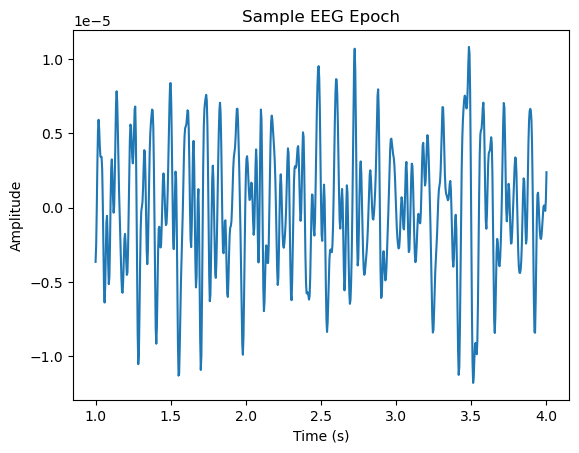

In [3]:
print("Data shape:", data.shape)

# Visualize a sample epoch
epoch_idx = 0
plt.plot(epochs.times, data[epoch_idx, 0, :])  # Plot the first channel of the first epoch
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sample EEG Epoch')
plt.show()
#(epochs, EEG channels, nbumber of time points in each epoch)

# Visual Representation of left and Right Hand Signals #

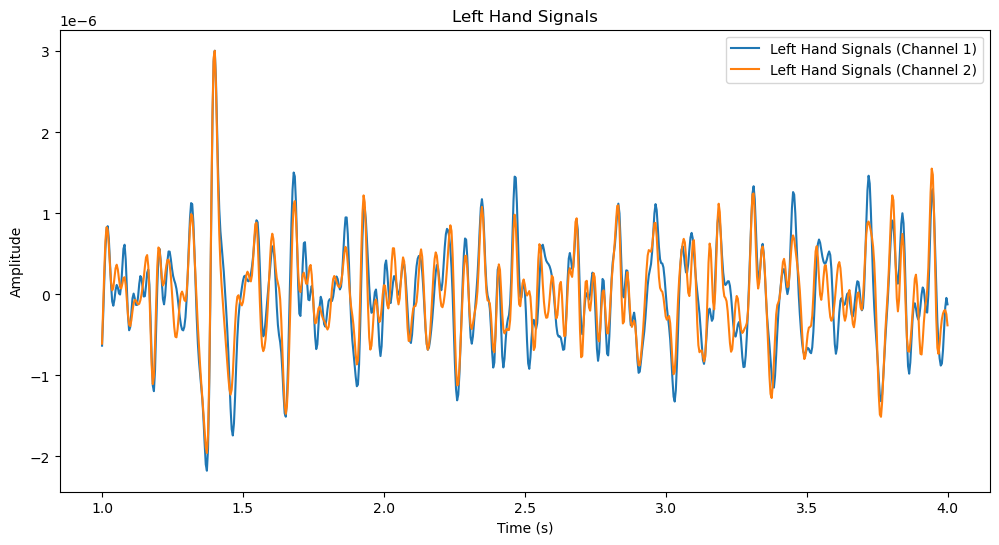

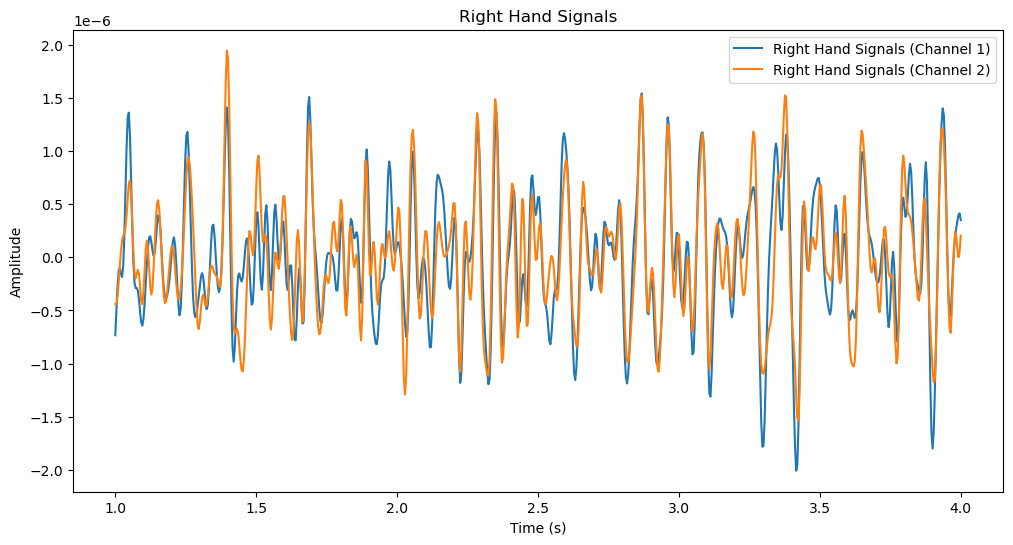

In [4]:
# Define the classes for left and right hand movements
left_class = 7
right_class = 8

# Filter and plot left hand signals
left_indices = np.where(y == left_class)[0]
left_signals = data[left_indices]

plt.figure(figsize=(12, 6))
plt.plot(epochs.times, np.mean(left_signals[:, 0, :], axis=0), label='Left Hand Signals (Channel 1)')
plt.plot(epochs.times, np.mean(left_signals[:, 1, :], axis=0), label='Left Hand Signals (Channel 2)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Left Hand Signals')
plt.legend()
plt.show()

# Filter and plot right hand signals
right_indices = np.where(y == right_class)[0]
right_signals = data[right_indices]

plt.figure(figsize=(12, 6))
plt.plot(epochs.times, np.mean(right_signals[:, 0, :], axis=0), label='Right Hand Signals (Channel 1)')
plt.plot(epochs.times, np.mean(right_signals[:, 1, :], axis=0), label='Right Hand Signals (Channel 2)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Right Hand Signals')
plt.legend()
plt.show()

# Scaling data 

In [5]:
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

data_csp = data_normalized.transpose(0, 2, 1) # common spacial pattern input, switch pos of 2, 1


# Training, Testing, Validation Split

In [6]:
from sklearn.model_selection import train_test_split

# 81% for training 
#6.3% for testing model 
#19% for validating model 

data_train, data_temp, y_train, y_temp = train_test_split(data_csp, y, test_size=0.19, random_state=42)
data_val, data_test, y_val, y_test = train_test_split(data_temp, y_temp, test_size=1/3, random_state=42)

#below are the splits used to achieve highest accuracy 
#0.2 = 69.%
#0.1975 = 65%
# num<0.1975 = 48% or less
#num>0.2 = 51% or less

# CSP 

In [7]:
label_encoder = LabelEncoder() #categorical label into numerical font
y_train_encoded = label_encoder.fit_transform(y_train) #uses fit tranform method to encode categorical labels 
y_val_encoded = label_encoder.transform(y_val) #encoder consistency on train and validation 

# Apply CSP transformation
n_components = 4  # You can experiment with different values
csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)

# Fit CSP on the training data
data_train_csp = csp.fit_transform(data_train, y_train_encoded)

# Transform the validation data using CSP
data_val_csp = csp.transform(data_val)

data_val_csp

print("Shape of data_train_csp:", data_train_csp.shape)

Computing rank from data with rank=None
    Using tolerance 85 (2.2e-16 eps * 751 dim * 5.1e+14  max singular value)
    Estimated rank (mag): 751
    MAG: rank 751 computed from 751 data channels with 0 projectors
Reducing data rank from 751 -> 751
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 83 (2.2e-16 eps * 751 dim * 5e+14  max singular value)
    Estimated rank (mag): 751
    MAG: rank 751 computed from 751 data channels with 0 projectors
Reducing data rank from 751 -> 751
Estimating covariance using EMPIRICAL
Done.
Shape of data_train_csp: (116, 4)


# Reshaping Data for model use

In [8]:
# Reshape the data to match the expected input shape of the Conv2D layer
data_train_csp = data_train_csp.reshape(data_train_csp.shape[0], data_train_csp.shape[1], 1, 1)
data_val_csp = data_val_csp.reshape(data_val_csp.shape[0], data_val_csp.shape[1], 1, 1)

print("Shape of data_train_csp:", data_train_csp.shape)

Shape of data_train_csp: (116, 4, 1, 1)


# CNN classification model (AKA. Star of the show) 

In [9]:
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(data_train_csp.shape[1], data_train_csp.shape[2], 1), padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Add dropout for regularization
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 1, 32)          320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 1, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 1, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 128)         0

# Model Compilation

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
class_weights = {0: 1, 1: 1}  # You can experiment with different values
history = model.fit(data_train_csp, y_train_encoded, epochs=20, validation_data=(data_val_csp, y_val_encoded),
                    batch_size=32, verbose=2, class_weight=class_weights)

Epoch 1/20
4/4 - 1s - loss: 4.7273e-08 - accuracy: 1.0000 - val_loss: 1.3923 - val_accuracy: 0.6111 - 691ms/epoch - 173ms/step
Epoch 2/20
4/4 - 0s - loss: 7.8103e-08 - accuracy: 1.0000 - val_loss: 1.4314 - val_accuracy: 0.6111 - 27ms/epoch - 7ms/step
Epoch 3/20
4/4 - 0s - loss: 5.4466e-08 - accuracy: 1.0000 - val_loss: 1.4304 - val_accuracy: 0.6111 - 26ms/epoch - 6ms/step
Epoch 4/20
4/4 - 0s - loss: 1.7470e-08 - accuracy: 1.0000 - val_loss: 1.3966 - val_accuracy: 0.6111 - 26ms/epoch - 7ms/step
Epoch 5/20
4/4 - 0s - loss: 3.0830e-08 - accuracy: 1.0000 - val_loss: 1.3849 - val_accuracy: 0.6111 - 26ms/epoch - 7ms/step
Epoch 6/20
4/4 - 0s - loss: 9.2490e-09 - accuracy: 1.0000 - val_loss: 1.3864 - val_accuracy: 0.6111 - 25ms/epoch - 6ms/step
Epoch 7/20
4/4 - 0s - loss: 1.3565e-07 - accuracy: 1.0000 - val_loss: 1.7785 - val_accuracy: 0.6667 - 27ms/epoch - 7ms/step
Epoch 8/20
4/4 - 0s - loss: 2.0656e-07 - accuracy: 1.0000 - val_loss: 1.5641 - val_accuracy: 0.6111 - 30ms/epoch - 7ms/step
Epoch

# Model evaluation


In [14]:
evaluation = model.evaluate(data_val_csp, y_val_encoded)
print("Validation Loss: {:.4f}".format(evaluation[0]))
print("Validation Accuracy: {:.2f}%".format(evaluation[1] * 100))

1/1 [==============================] - 0s 17ms/step - loss: 1.2706 - accuracy: 0.7222
Validation Loss: 1.2706
Validation Accuracy: 72.22%


# Exporting model and importing it again for testing


In [21]:
# Save the model
model.save('eeg_classification_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('eeg_classification_model.h5')


C:\Users\varun\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model in action

In [22]:
import numpy as np

# Randomly select epochs from the validation dataset
num_random_samples = 5  # Number of random samples to test
random_indices = np.random.choice(data_val_csp.shape[0], num_random_samples, replace=False)
random_samples = data_val_csp[random_indices]

# Predict classes for the random samples
predictions = loaded_model.predict(random_samples)

# Get the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted class indices back to the original labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Display the results
for i in range(num_random_samples):
    print(f"Sample {i + 1}: Predicted Label = {predicted_labels[i]}")


1/1 [==============================] - 0s 95ms/step
Sample 1: Predicted Label = 8
Sample 2: Predicted Label = 7
Sample 3: Predicted Label = 8
Sample 4: Predicted Label = 8
Sample 5: Predicted Label = 7
